<a href="https://colab.research.google.com/github/dharshu2323/Pytorch-GAN-Mnist/blob/main/Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [4]:
transform = transforms.ToTensor()

In [7]:
class Encoder(nn.Module):
    def __init__(self,input_size=28*28,hidden_size1=128,hidden_size2=16,z_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_size ,hidden_size1)
        self.fc2 = nn.Linear(hidden_size1,hidden_size2)
        self.fc3 = nn.Linear(hidden_size2,z_dim)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
class Decoder(nn.Module):
    def __init__(self,output_size=28*28,hidden_size1=128,hidden_size2=16,z_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(z_dim , hidden_size2)
        self.fc2 = nn.Linear(hidden_size2,hidden_size1)
        self.fc3 = nn.Linear(hidden_size1,output_size)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [27]:
train_dataset = torchvision.datasets.MNIST(root = "./data",train = True,download = True ,transform = transform)
valid_dataset = torchvision.datasets.MNIST(root = "./data",train = False,download=True,transform=transform)

In [29]:
train_dl = torch.utils.data.DataLoader(train_dataset , batch_size = 100)

In [30]:
print(train_dl)

In [25]:
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
enc = Encoder().to(device)
dec = Decoder().to(device)

In [11]:
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

In [12]:
train_loss = []

In [13]:
num_epochs = 100

In [14]:
for epoch in range(num_epochs):
    train_epoch_loss = 0
    for (imgs , _) in train_dl:
        imgs = imgs.to(device)
        imgs = imgs.flatten(1)
        latents = enc(imgs)
        output = dec(latents)
        loss = loss_fn(output , imgs)
        train_epoch_loss += loss.cpu().detach().numpy()
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
    train_loss.append(train_epoch_loss)

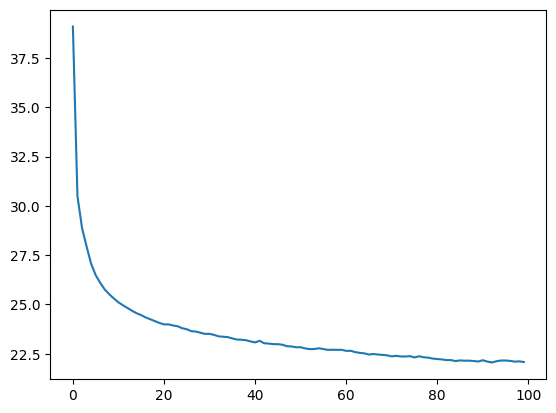

In [15]:
plt.plot(train_loss)

In [16]:
values = None
all_labels = []

with torch.no_grad():
  for (imgs , labels) in train_dl:
    imgs = imgs.to(device)
    imgs = imgs.flatten(1)
    all_labels.extend(list(labels.numpy()))
    latents = enc(imgs)
    if values is None:
      values = latents.cpu()
    else:
      values = torch.vstack([values , latents.cpu()])

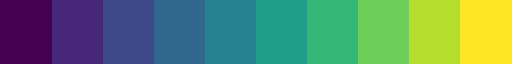

In [18]:
cmap = plt.get_cmap('viridis', 10)
cmap

In [19]:
all_labels = np.array(all_labels)
values = values.numpy()

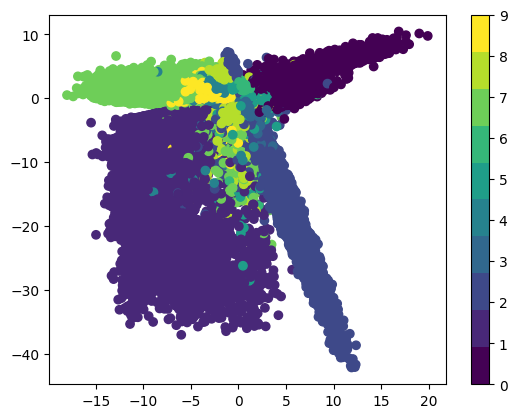

In [20]:
pc = plt.scatter(values[: , 0] , values[: , 1] , c = all_labels , cmap = cmap)
plt.colorbar(pc)

In [21]:
all_means = {}
for i in range(10):
  inds = np.argwhere(all_labels == i)
  num_latents = values[inds].squeeze()
  mean = num_latents.mean(axis = 0)
  all_means[i] = (mean[0] , mean[1])

In [22]:
torch.Tensor(all_means[0])[None , ...].shape

torch.Size([1, 2])

In [24]:
with torch.no_grad():
  pred = dec(torch.Tensor(all_means[5])[None , ...].to(device)).cpu()
transforms.ToPILImage()(pred.reshape(1 , 28 , 28))